In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import cv2
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, Dropout
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from skimage.io import imread
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['keras-pretrained-models', 'pytorch-pretrained-models', 'cat-dataset']


In [2]:
# Define some Paths
input_path = Path('../input/cat-dataset/cats')
cats = os.listdir(input_path)
print("Total number of sub-directories found: ", len(cats))

# Store the meta-data in a dataframe for convinience 
data = []
for folder in cats:
    new_dir = input_path / folder
    images = sorted(new_dir.glob('*.jpg'))
    annotations = sorted(new_dir.glob('*.cat'))
    n = len(images)
    for i in range(n):
        img = str(images[i])
        annotation = str(annotations[i])
        data.append((img, annotation))
    print("Processed: ", folder)
print(" ")        

Total number of sub-directories found:  7
Processed:  CAT_00
Processed:  CAT_06
Processed:  CAT_03
Processed:  CAT_04
Processed:  CAT_05
Processed:  CAT_01
Processed:  CAT_02
 


In [3]:
df = pd.DataFrame(data=data, columns=['img_path', 'annotation_path'], index=None)
print("Total number of samples in the dataset: ", len(df))
print(" ")
df.head(10)

Total number of samples in the dataset:  9997
 


,img_path,annotation_path
0,../input/cat-dataset/cats/CAT_00/00000001_000.jpg,../input/cat-dataset/cats/CAT_00/00000001_000....
1,../input/cat-dataset/cats/CAT_00/00000001_005.jpg,../input/cat-dataset/cats/CAT_00/00000001_005....
2,../input/cat-dataset/cats/CAT_00/00000001_008.jpg,../input/cat-dataset/cats/CAT_00/00000001_008....
3,../input/cat-dataset/cats/CAT_00/00000001_011.jpg,../input/cat-dataset/cats/CAT_00/00000001_011....
4,../input/cat-dataset/cats/CAT_00/00000001_012.jpg,../input/cat-dataset/cats/CAT_00/00000001_012....
5,../input/cat-dataset/cats/CAT_00/00000001_016.jpg,../input/cat-dataset/cats/CAT_00/00000001_016....
6,../input/cat-dataset/cats/CAT_00/00000001_017.jpg,../input/cat-dataset/cats/CAT_00/00000001_017....
7,../input/cat-dataset/cats/CAT_00/00000001_020.jpg,../input/cat-dataset/cats/CAT_00/00000001_020....
8,../input/cat-dataset/cats/CAT_00/00000001_024.jpg,../input/cat-dataset/cats/CAT_00/00000001_024....
9,../input/cat-dataset/cats/CAT_00/00000001_027.jpg,../input/cat-dataset/cats/CAT_00/00000001_027....


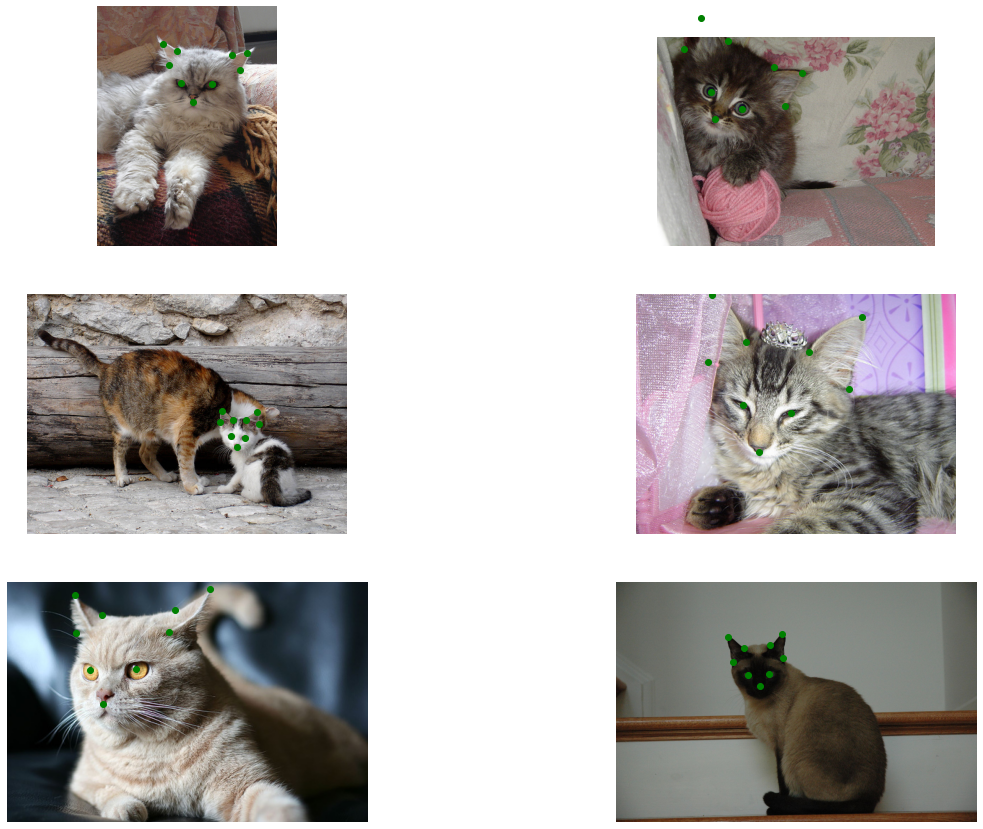

In [4]:
# Plot some cats and respective annotations
f, ax = plt.subplots(3,2, figsize=(20,15))

# Get six random samples
samples = df.sample(6).reset_index(drop=True)

for i, sample in enumerate(samples.values):
    # Get the image path
    sample_img = df['img_path'][i]
    # Get the annotation path
    sample_annot = df['annotation_path'][i]
    # Read the annotation file
    f = open(sample_annot)
    points = f.read().split(' ')
    points = [int(x) for x in points if x!='']
    # Get the list of x and y coordinates
    xpoints = points[1:19:2]
    ypoints = points[2:19:2]
    # close the file
    f.close()
    
    ax[i//2, i%2].imshow(imread(sample_img))
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].scatter(xpoints, ypoints, c='g')
    
plt.show()    

In [5]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [6]:
# Copy the weights from your input files to the cache directory
!cp ../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 ~/.keras/models/

cp: cannot stat '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5': No such file or directory


In [7]:
# A simple data generator
def data_gen(data, batch_size=32):
    # Get total number of samples in the data
    n = len(data)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,18), dtype=np.float32)
    
    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data['img_path'][idx]
            #print(img_name)
            img = imread(img_name)
            h,w,_ = img.shape
            sample_img = cv2.resize(img, (224,224))
            
            # Get the annotation path
            annot = data['annotation_path'][idx]
            # Read the annotation file
            f = open(annot)
            points = f.read().strip().split(' ')[1:]
            points = [float(x) for x in points]
            
            xcoords = points[0:18:2]
            ycoords = points[1:18:2]
            
            xpoints = np.array(xcoords, dtype=np.float32) / w
            ypoints = np.array(ycoords, dtype=np.float32) / h
            
            #xpoints *=224
            #ypoints *=224
            
            
            final_points = []
            for k in range(len(xpoints)):
                final_points.append(xpoints[k])
                final_points.append(ypoints[k])
            
            f.close()
            
            final_points = np.array(final_points)
            batch_data[j] = sample_img
            batch_labels[j] = final_points
        batch_data = preprocess_input(batch_data)
        yield batch_data, batch_labels
        i +=1  

In [8]:
def build_model():
    base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')
    base_model_output = base_model.output
    x = Flatten(name='flatten')(base_model_output)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(18, name='fc3')(x)
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Model(inputs=base_model.input, outputs=x)
    #model = Model(inputs=input_img, outputs=x)
    return model

In [9]:
model = build_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=111)
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

train_df = train_df.reset_index(drop=True)
valid_df = train_df.reset_index(drop=True)

Number of training samples:  8997
Number of validation samples:  1000


In [11]:
nb_epochs = 50
batch_size = 32
nb_tr_batches = len(train_df) // batch_size
nb_val_batches = len(valid_df) // batch_size
train_data_gen = data_gen(train_df, batch_size)
valid_data_gen = data_gen(valid_df, batch_size)

In [12]:
#opt = SGD(lr=0.001, momentum=0.9, nesterov=True)
estop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
opt = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
model.fit_generator(train_data_gen,e`pochs=nb_epochs, steps_per_epoch=nb_tr_batches,
                    validation_data=valid_data_gen, validation_steps=nb_val_batches, 
                    callbacks=[estop])

Epoch 1/50
281/281 [==============================] - 234s 831ms/step - loss: 13.0561 - val_loss: 0.9178
Epoch 2/50
281/281 [==============================] - 37s 132ms/step - loss: 0.1015 - val_loss: 0.0877
Epoch 3/50
281/281 [==============================] - 37s 131ms/step - loss: 0.0553 - val_loss: 0.0511
Epoch 4/50
 79/281 [=======>......................] - ETA: 13s - loss: 0.0368